https://github.com/NanoComp/meep/blob/master/python/examples/straight-waveguide.ipynb  

https://stackoverflow.com/questions/29454002/filenotfounderror-errno-2-no-such-file-or-directory-ffmpeg


In [1]:
import math
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using MPI version 3.1, 1 processes


In [2]:
def phc_trans(PhC = True, lengthPhC = 100, decay_check=0, T_decay=500):
    """
    <変数の説明>
    PhC...PhC(フォトニック決勝)を配置するかどうか。Falseで直線導波路
    lengthPhC...PhC導波方向の長さ
    widthPhC...PhC垂直方向の幅。PMLと被ってるので適当。
    ConnectionWaveguide...PhCに接続するSi導波路(棒の部分)の長さ
    wgi...導波路の幅を調整する。1で丸穴一個分空いてることを意味する。0.7とかにすると狭くなってバンドの形が変わる、っていうのはDaii君の研究とも絡む。
    r...穴の半径。ふつうはa/4くらい。meepだと格子定数は1で固定だから、格子定数との比を入力すればOK
    n_eff...屈折率。2次元だと2.5~2.7くらいにしておくと3次元のSi系(n_Si=3.48)と結果が近くなる。違う材料を使うときは要調整、通常はdefaultで大丈夫。
    fcen...入力光（ガウシアンビーム）の中心周波数。知りたいPhCバンドの周波数近くに設定する
    df...入力光（ガウシアンビーム）の半値幅（で合ってる？）
    nfreq...入力光（ガウシアンビーム）のきめ細かさ
    resolution...メッシュの細かさ。2^nにすると計算が軽くなるらしい。
    T_dacay...反復計算数。小さいと誤差が増え、大きいと時間がかかる。sim.run(until_after_sources=...)で計算時間を見積もってから変えるとよさそう
    decay_check...解の収束をどこで判定するか、位置を指定。defaultでOK

    <備考>
    ・meepでは格子定数aはパラメータに含まれないので設定不要
    　誘電体を使うときは入力するらしい（スケール依存性が出るから）
    ・THzやnmは使用せず、すべて規格化周波数で入力する (周波数はωa/2πcで直す)
    """
    ##### setting of parameters #####
    a = 1 # CADに移行しやすいように予め設定しておく
    widthPhC = 10
    ConnectionWaveguide = 5
    wgi = 1/2 #/np.sqrt(3)/2
    whetero = 1/np.sqrt(3)/4
    r = 1/4
    d_0 = 0.75*a
    yshift = 1/(2*np.sqrt(3)) + 1/6*np.sqrt(3)/2*d_0
    n_eff = 2.6
    fcen = 0.3 
    df = 0.2
    nfreq = 500 # number of frequencies at which to compute flux
    resolution = 16

    connect = 5
    #####
    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC
    Nx = int(lengthPhC)
    Ny = int(widthPhC)
    eps = n_eff**2

    ##### settings of geometry #####
    # initialization
    cell = mp.Vector3(length,width*np.sqrt(3),0)

    # Si waveguide
    waveguide = mp.Block(mp.Vector3(mp.inf,wgi*np.sqrt(3),mp.inf),
                            center=mp.Vector3(),
                            material=mp.Medium(epsilon=eps))
    geometry = [waveguide]

    # PhC
    if PhC:
        # triangle
        tri_u = [
                mp.Vector3(-np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3),
                mp.Vector3( np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3),
                mp.Vector3(            0,   1)*d_0/np.sqrt(3),
                ]
        tri_d = [
                mp.Vector3(-np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3)*(-1),
                mp.Vector3( np.sqrt(3)/2,-1/2)*d_0/np.sqrt(3)*(-1),
                mp.Vector3(            0,   1)*d_0/np.sqrt(3)*(-1),
                ]

        # slab
        blk = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                                center=mp.Vector3(),
                                material=mp.Medium(epsilon=eps))

        geometry.append(blk)
        
        # arrange air-holes
        for j in range(Ny):
            for i in range(Nx+1):
                shift_y = np.sqrt(3)
                geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift + 1/(np.sqrt(3)) + shift_y*(j+1/2))))                
                geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift -(1/(np.sqrt(3)) + shift_y*(j+1/2)))))            
                geometry.append(mp.Prism(tri_d, height = 1, center=mp.Vector3(i-Nx/2, yshift +  1/(np.sqrt(3)) + shift_y*j )))

            if j == 0:
                for i in range(connect,Nx+1-connect):
                    geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-Nx/2, yshift - (1/(np.sqrt(3)) + shift_y*j))))
            else:
                for i in range(Nx+1):
                    geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-Nx/2, yshift - (1/(np.sqrt(3)) + shift_y*j))))
                    
        #for i in range(connect,Nx+2-connect):
        for i in range(Nx+1):
            geometry.append(mp.Prism(tri_u, height = 1, center=mp.Vector3(i-(Nx+1)/2, yshift - (1/(np.sqrt(3)) + shift_y*(-1/2)))))


                #geometry.append(mp.Cylinder(r, center=mp.Vector3(i-N/2,-wgi*np.sqrt(3)/2)))

    # Gaussian
    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                            component=mp.Hz,
                            center=mp.Vector3(-length/2 +1,0),
                            size=mp.Vector3(0,wgi*np.sqrt(3)))
                ]

    # PML
    pml_layers = [mp.PML(1.0)]

    # z-symmetry (上下対称なら計算が軽くなる。対称性が無いなら消す)
    #sym = [mp.Mirror(mp.Y, phase=-1)]
    

    ####
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        #symmetries=sym,
                        resolution=resolution)

    #tran_in = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2-1,0),size=mp.Vector3(0, 2*wgi))
    tran_out = mp.FluxRegion(center=mp.Vector3(length/2-3/2,0),size=mp.Vector3(0, 2*wgi))
    #trans_in = sim.add_flux(fcen, df, nfreq, tran_in)
    trans_out = sim.add_flux(fcen, df, nfreq, tran_out)

    # show geometry
    %matplotlib inline
    f = plt.figure(dpi=150)
    sim.plot2D(ax=f.gca())
    plt.show()    

    #sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(decay_check), 1e-3))
    sim.run(until=T_decay)

    freqs = mp.get_flux_freqs(trans_out)
    #psd_in = mp.get_fluxes(trans_in)
    psd_out = mp.get_fluxes(trans_out)

    return freqs, psd_out


-----------
Initializing structure...
time for choose_chunkdivision = 0.000211 s
Working in 2D dimensions.
Computational cell is 30 x 17.3125 x 0 with resolution 16
     block, center = (0,0,0)
          size (1e+20,0.866025,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
time for set_epsilon = 0.197283 s
-----------


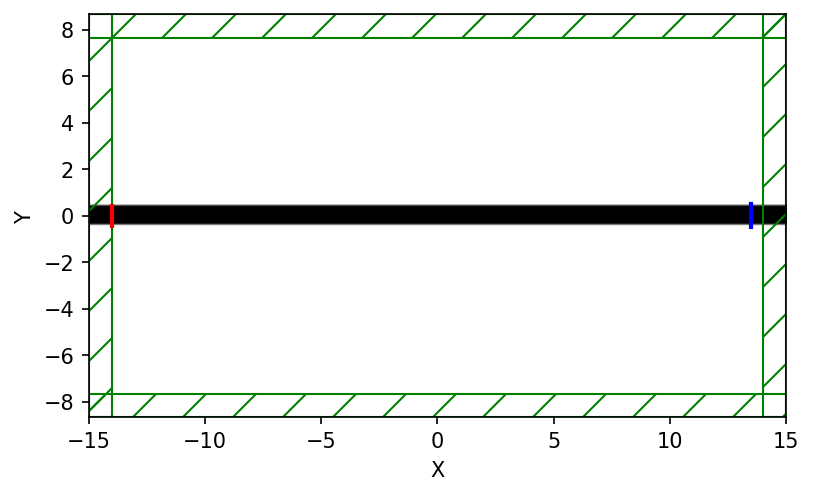

In [3]:
freqs_wo, psd_out_wo = phc_trans(PhC = False, lengthPhC = 20, decay_check=10, T_decay=500)
freqs_w,  psd_out_w  = phc_trans(PhC = True, lengthPhC = 40, decay_check=20, T_decay=10000)

In [ ]:
plt.plot(freqs_wo,psd_out_wo)
plt.grid(True)

In [ ]:
plt.plot(freqs_w,psd_out_w)
plt.grid(True)

In [ ]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

In [ ]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

In [ ]:
a = 470
c_const = 299792458

freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
#plt.xlim([0.28,0.30])
plt.yscale('log')
plt.grid(True)

In [ ]:
freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.xlim([1450,1550])
plt.yscale('log')
plt.grid(True)

In [ ]:
df = pd.DataFrame()
df["wavelength"] = freqs
df["transmittance"] = np.array(psd_out_w)/np.array(psd_out_wo)
df.to_csv("201029_waveguide_VPhCtriangle_zigzag.ipynb_transmittance.csv")


In [ ]:
df